<font size=4>I will explain how to use codes to compute important quantities in the thesis. The necessary libraries are below. Change the file path of JIDT Java file in `Psi.py`, `Delta_and_Gamma.py`, `Psi_modified.py`, `Delta_modified.py` and `bias.py` if needed.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import bias
import Delta_and_Gamma as DG
import Psi as P
import Psi_modified as mP
import Delta_modified as mD
from XYModel2D import XYModel2D

<font size=4> File `XYModel2D.py` can simulate XY model for a certain system size $L$ and temperature $T$. It can be used as follows:


Starting annealing simulation at T = 1.000 
equilibrium state is reached at T=1.000


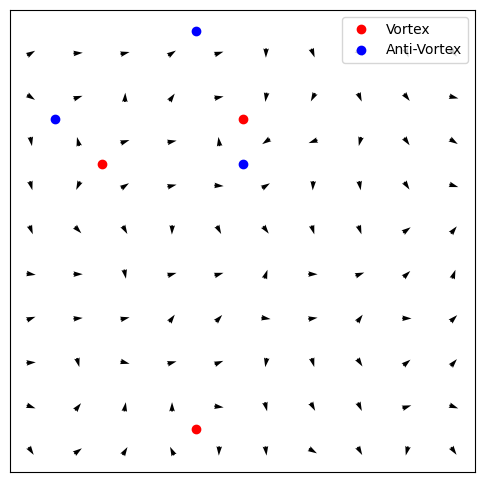

In [4]:
# set L and T
L = 10
T = 1.0
# initiate our model
model = XYModel2D(L, T)
# simulate the model to the equilibrium
model.equilibrate()
# can plot the model with vortices if they exist
model.plot_spin_with_vortices()

<font size=4> `XYModel2D.py` also includes the method to compute heat capacity and helicity modulus in x direction.

In [6]:
print('heat capcity=', model.heat_capacity())
print('helicity modulus=',model.helicity_modulus_x())

heat capcity= 1.0126744102250813
helicity modulus= 0.5088525379215877


<font size=4> There is a `sample` method to collect macroscopic microscopic features.

In [8]:
V_t, X_t = model.sample(10000) # macro and micro samples for 10000 'seconds'

<font size=4> Use `Psi.py` and `Delta_and_Gamma.py`, we can compute the quantities $\psi_{t,t+1}$, $\Delta_{t,t+1}$ and $\Gamma_{t,t+1}$. Moreover, one can compute the redundancy estimated by MMI PID and therefore $\psi_{t,t+1}^{red}$ and $\Delta_{t,t+1}^{red}$.

In [10]:
X_t = np.array(X_t)
macro, micros, red_MMI = P.Psi(V_t, X_t)
print(f'Psi={macro-micros:.6f}, Psi without redundancy={macro-micros+(L*L-1)*red_MMI:.6f}, where the the redundancy is {red_MMI:.6f}')

Psi=-12.071811, Psi without redundancy=-1.220917, where the the redundancy is 0.109605


In [11]:
Delta, Delta_without_red, Gamma = DG.delta_gamma(V_t, X_t)
print(f'Delta={Delta:.6f}, Delta without redundancy={Delta_without_red:.6f}, and Gamma={Gamma:.6f}')

Delta=-204.235474, Delta without redundancy=-15.074746, and Gamma=0.143969


<font size=4> `Psi_modified.py` and `Delta_modified.py` compute $B(X_t^i, X_t^j; V_{t+1})$ and $B(X_t^i, X_t^j; X_{t+1}^k)$ $\forall i,j$ respectively.

In [13]:
B_macro = mP.detect_syn(X_t, V_t)
# can plot a histogram of B(X_t^i, X_t^j; V_{t+1}) if need
# plt.hist(B_macro[:,0])

B_ave = np.mean(B_macro[:,0]) # the mean of B(X_t^i, X_t^j; V_{t+1})
B_max = np.max(B_macro[:,0]) # the maximum of B(X_t^i, X_t^j; V_{t+1})
red_MMI_ave = np.mean(B_macro[:,1]) # the estimated redundency
syn_MMI_ave = np.mean(B_macro[:,2]) # the estimated synergy
print(f'The mean is {B_ave:.6f} and the maximum is {B_max:.6f}. By MMI PID, the average redundancy is {red_MMI_ave:.6f} and the average synergy is {syn_MMI_ave:.6f}')

The mean is -0.135321 and the maximum is -0.095111. By MMI PID, the average redundancy is 0.120080 and the average synergy is -0.015240


In [14]:
B_micro = mD.detect_syn_single(0, X_t) # B(X_t^i, X_t^j; X_{t+1}^1)
# can plot a histogram if need
# plt.hist(B_micro)

# for all k, use mD.detect_syn_all(X_t)
# but this one takes much time

print(f'The maximum is {np.max(B_micro)}')

The maximum is -2.716929205161369


<font size=4> The statistical significance of the estimate provided by JIDT can be computed using `bias.py` as following:

In [16]:
arr1 = np.array([np.cos(X_t[:,0]), np.sin(X_t[:,0])]).T
arr2 = np.array([np.cos(X_t[:,1]), np.sin(X_t[:,1])]).T
arr3 = np.array([np.cos(X_t[:,2]), np.sin(X_t[:,2])]).T
comb = np.hstack((arr1,arr2))

print('macro to macro:', bias.mi_uncertainty(V_t, V_t, bias.calc_mi_kraskov))
print('micro to macro:', bias.mi_uncertainty(arr1, V_t, bias.calc_jmi_kraskov))
print('micros to macro:', bias.mi_uncertainty(comb, V_t, bias.calc_jmi_kraskov))
print('micro to micro:', bias.mi_uncertainty(arr1, arr3, bias.calc_jmi_kraskov_XX))
print('micros to micro:', bias.mi_uncertainty(comb, arr3, bias.calc_jmi_kraskov_XX))
print('macro to micro:', bias.mi_uncertainty(V_t, arr1, bias.calc_mi_kraskov_2d_VX))

macro to macro: 0.00017734360572151564
micro to macro: 0.0009421125626640407
micros to macro: 0.0013723003139208515
micro to micro: 2.3950249865918636e-06
micros to micro: 0.0002229139294550932
macro to micro: 0.007798042351141211


<font size=4> Finite-size scaling method

In [18]:
from scipy.optimize import curve_fit

def f(L, TBKT, a, b):
    r'''
    $T^*(L)$ with parameters $T_{BKT}$, $a$ and $b$
    '''
    x = np.log(b*L)
    return TBKT + a/x**2

def BKT(L, Tstar, sigma):
    '''
    Fit the function
    '''
    # initial values
    TBKT0 = np.median(Tstar)
    b0 = 1.0
    c0 = 1.0
    a0 = np.median((Tstar - TBKT0) * (np.log(b0* L)**2)) 
    p0 = [TBKT0, a0, b0]
    bounds = ([min(Tstar)-0.5, -np.inf, -5], [max(Tstar)+0.5, np.inf, 5])
    # fit the curve
    popt, pcov = curve_fit(f, L, Tstar, p0=p0, sigma=sigma, absolute_sigma=True, bounds=bounds)
    TBKT, a, b = popt
    perr = np.sqrt(np.diag(pcov))
    print(f"T_BKT = {TBKT:.6f} ± {perr[0]:.6f}")
    print(f"a     = {a:.6f} ± {perr[1]:.6f}")
    print(f"b     = {b:.6f} ± {perr[2]:.6f}")
    return TBKT, a, b, perr

def plot_estimate(L, Tstar, sigma):
    TBKT, a, b, perr = BKT(L, Tstar, sigma)
    Ls = np.logspace(1,10)
    Ts = f(Ls, TBKT, a ,b)
    plt.plot(1/np.log(b*Ls), Ts, c='r')
    plt.plot([0,1/np.log(b*Ls[-1])], [TBKT, Ts[-1]], c='r')
    plt.scatter(1/np.log(b*L), Tstar, c='blue', label=r'$T^*(L)$')
    plt.scatter(0, TBKT, c='none',edgecolors='blue', marker='o', label=r'$T_{BKT}(\infty)\approx$'+f'{TBKT:.6f}')
    plt.errorbar(0, TBKT, yerr=perr[0], capsize=2, ecolor='blue', label='uncertainty')
    plt.xlim(-0.01)
    plt.xlabel(r'$\dfrac{1}{\log(bL)}$', fontsize = 15)
    plt.ylabel('Temperatures', fontsize = 15)
    plt.grid()
    plt.legend()
    plt.show()

T_BKT = 0.837510 ± 0.132773
a     = 1.241493 ± 1.382541
b     = 0.442759 ± 0.294254


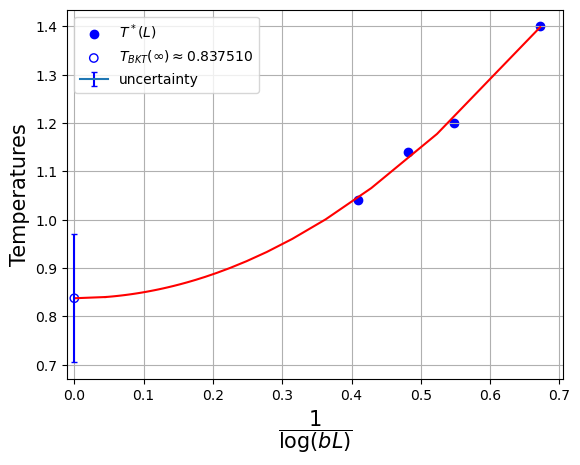

In [19]:
# Example: the maximum of B_ave
L = np.array([10, 14, 18, 26], dtype=float)
Tstar = np.array([1.4, 1.2, 1.14, 1.04], dtype=float)
sigma = np.array([0.02, 0.02, 0.02, 0.02])
plot_estimate(L, Tstar, sigma)